# Infer CNV on lung cancer dataset

In [1]:
import scanpy as sc
import infercnvpy as cnv
import matplotlib.pyplot as plt

sc.settings.set_figure_params(figsize=(5, 5))

/opt/hostedtoolcache/Python/3.8.7/x64/lib/python3.8/site-packages/traitlets/traitlets.py:3030: FutureWarning: --rc={'figure.dpi': 96} for dict-traits is deprecated in traitlets 5.0. You can pass --rc <key=value> ... multiple times to add items to a dict.
  warn(


In [2]:
sc.logging.print_header()

scanpy==1.7.0 anndata==0.7.5 umap==0.5.0 numpy==1.20.0 scipy==1.6.0 pandas==1.2.1 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.8.3 leidenalg==0.8.3


/opt/hostedtoolcache/Python/3.8.7/x64/lib/python3.8/site-packages/umap/__init__.py:9: UserWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn("Tensorflow not installed; ParametricUMAP will be unavailable")


## Loading the example dataset

In [3]:
adata = cnv.datasets.maynard2020_3k()
adata.var.loc[:, ["ensg", "chromosome", "start", "end"]].head()

  0%|          | 0.00/49.5M [00:00<?, ?B/s]

  5%|▍         | 2.45M/49.5M [00:00<00:01, 25.5MB/s]

 17%|█▋        | 8.23M/49.5M [00:00<00:00, 46.2MB/s]

 40%|████      | 20.0M/49.5M [00:00<00:00, 81.1MB/s]

 82%|████████▏ | 40.5M/49.5M [00:00<00:00, 134MB/s] 

100%|██████████| 49.5M/49.5M [00:00<00:00, 117MB/s]

,ensg,chromosome,start,end
symbol,,,,
AL645933.5,ENSG00000288587.1,chr6,31400702,31463705
AC010184.1,ENSG00000288585.1,chr3,141449745,141456434
AC023296.1,ENSG00000288580.1,chr8,2923568,2926689
AL117334.2,ENSG00000288577.1,chr20,3406380,3410036
AC107294.4,ENSG00000288576.1,chr3,184778723,184780720


Let's first inspect the UMAP plot based on the transcriptomics data:

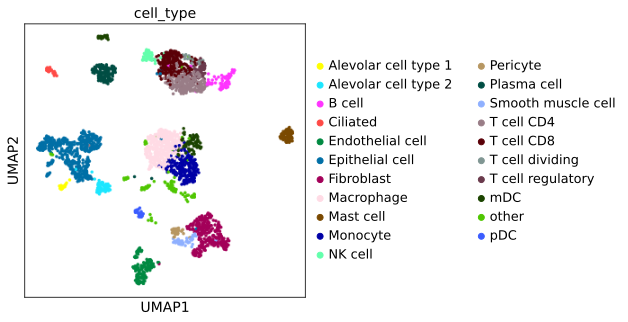

In [4]:
sc.pl.umap(adata, color="cell_type")

## Running infercnv

In [5]:
# We provide all immune cell types as "normal cells".
cnv.tl.infercnv(
    adata,
    reference_key="cell_type",
    reference_cat=[
        "B cell",
        "Macrophage",
        "Mast cell",
        "Monocyte",
        "NK cell",
        "Plasma cell",
        "T cell CD4",
        "T cell CD8",
        "T cell regulatory",
        "mDC",
        "pDC",
    ],
    window_size=250,
)

/opt/hostedtoolcache/Python/3.8.7/x64/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:46<00:00, 46.51s/it]

100%|██████████| 1/1 [00:46<00:00, 46.51s/it]

Now, we can plot smoothed gene expression by cell-type and chromosome. 
We can observe that the Epithelial cell cluster, which consists largely of tumor cells, appears
to be subject to copy number variation. 

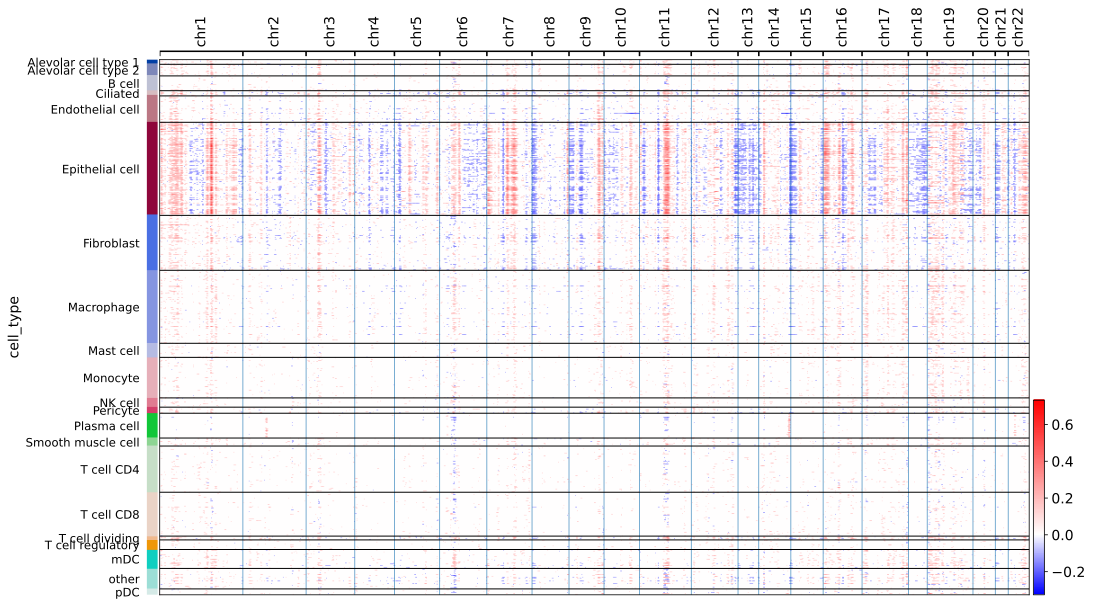

In [6]:
cnv.pl.chromosome_heatmap(adata, groupby="cell_type")

## Clustering by CNV profiles and identifying tumor cells

In [7]:
cnv.tl.pca(adata)
cnv.pp.neighbors(adata)
cnv.tl.leiden(adata)

After running leiden clustering, we can plot the chromosome heatmap 
by CNV clusters. We can observe that, as opposted to the clusters 
at the bottom, the clusters at the top have essentially no differentially expressed genomic regions. 
The differentially expressed regions are likely due to copy number variation and the respective 
clusters likely represent tumor cells. 

         Falling back to preprocessing with `sc.pp.pca` and default params.


categories: 0, 1, 2, etc.
var_group_labels: chr1, chr2, chr3, etc.


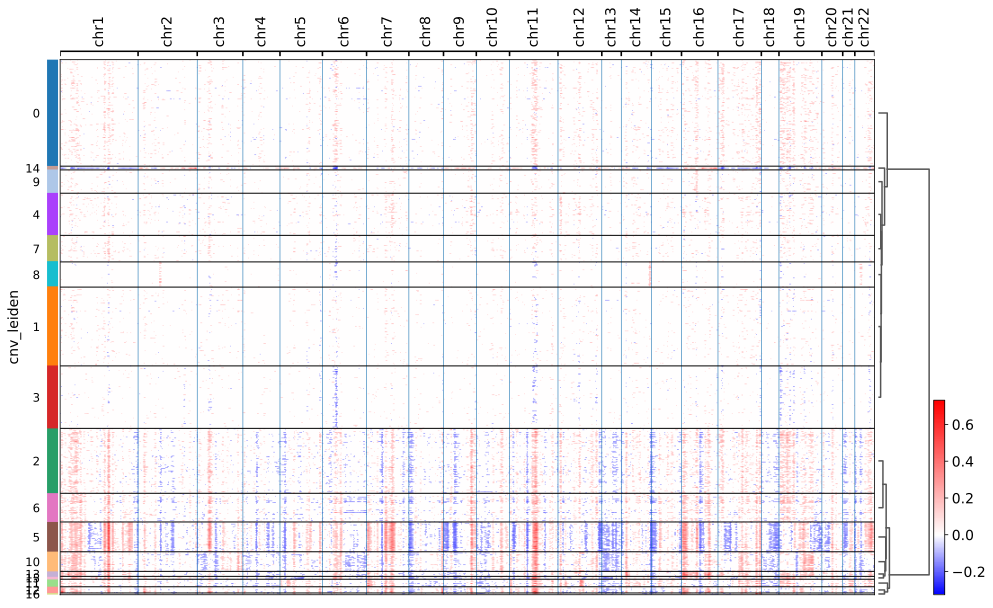

In [8]:
cnv.pl.chromosome_heatmap(adata, groupby="cnv_leiden", dendrogram=True)

### UMAP plot of CNV profiles

In [9]:
cnv.tl.umap(adata)
cnv.tl.cnv_score(adata)

The UMAP plot consists of a large blob of "normal" cells and several smaller clusters
with distinct CNV profiles. Except for cluster "12", which consists of ciliated cells, 
the isolated clusters are all epithelial cells. These are likely tumor cells and each 
cluster represents an individual sub-clone.

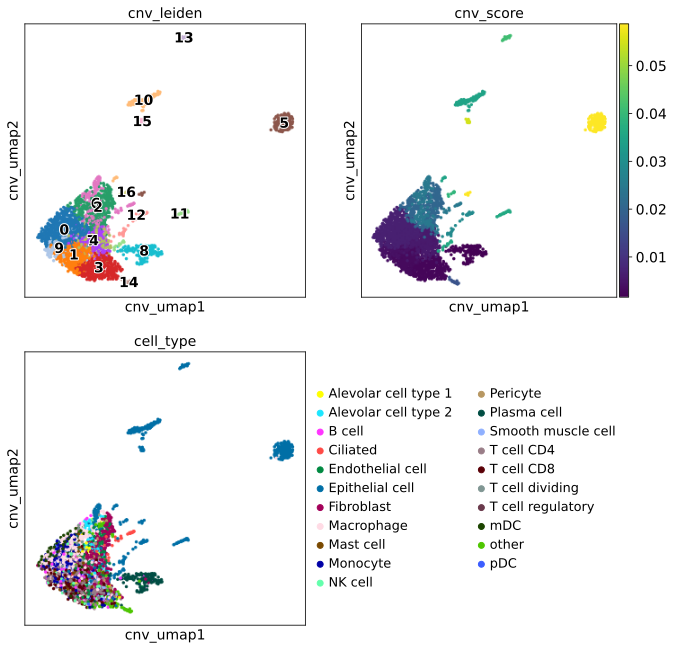

In [10]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(11, 11))
ax4.axis("off")
cnv.pl.umap(
    adata,
    color="cnv_leiden",
    legend_loc="on data",
    legend_fontoutline=2,
    ax=ax1,
    show=False,
)
cnv.pl.umap(adata, color="cnv_score", ax=ax2, show=False)
cnv.pl.umap(adata, color="cell_type", ax=ax3)

We can also visualize the CNV score and clusters on the transcriptomics-based UMAP plot. 
Again, we can see that there are subclusters of epithelial cells that belong
to a distinct CNV cluster, and that these clusters tend to have the 
highest CNV score. 

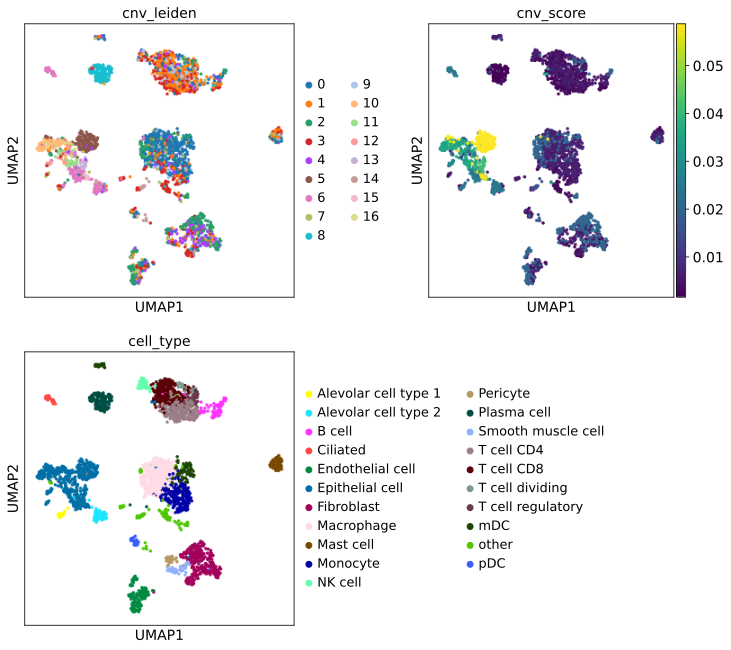

In [11]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(
    2, 2, figsize=(12, 11), gridspec_kw=dict(wspace=0.5)
)
ax4.axis("off")
sc.pl.umap(adata, color="cnv_leiden", ax=ax1, show=False)
sc.pl.umap(adata, color="cnv_score", ax=ax2, show=False)
sc.pl.umap(adata, color="cell_type", ax=ax3)

### Classifying tumor cells

Based on these observations, we can now assign cell to either "tumor" or "normal". 
To this end, we add a new column `cnv_status` to `adata.obs`. 

In [12]:
adata.obs["cnv_status"] = "normal"
adata.obs.loc[
    adata.obs["cnv_leiden"].isin(["13", "9", "15", "5", "11", "10", "16"]), "cnv_status"
] = "tumor"

... storing 'cnv_status' as categorical


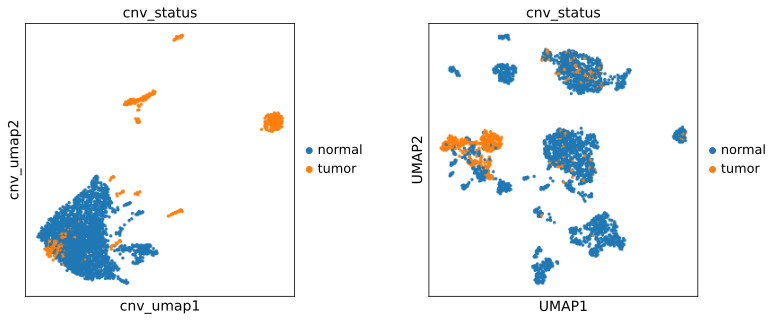

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw=dict(wspace=0.5))
cnv.pl.umap(adata, color="cnv_status", ax=ax1, show=False)
sc.pl.umap(adata, color="cnv_status", ax=ax2)

Now, we can plot the CNV heatmap for tumor and normal cells separately: 

/opt/hostedtoolcache/Python/3.8.7/x64/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


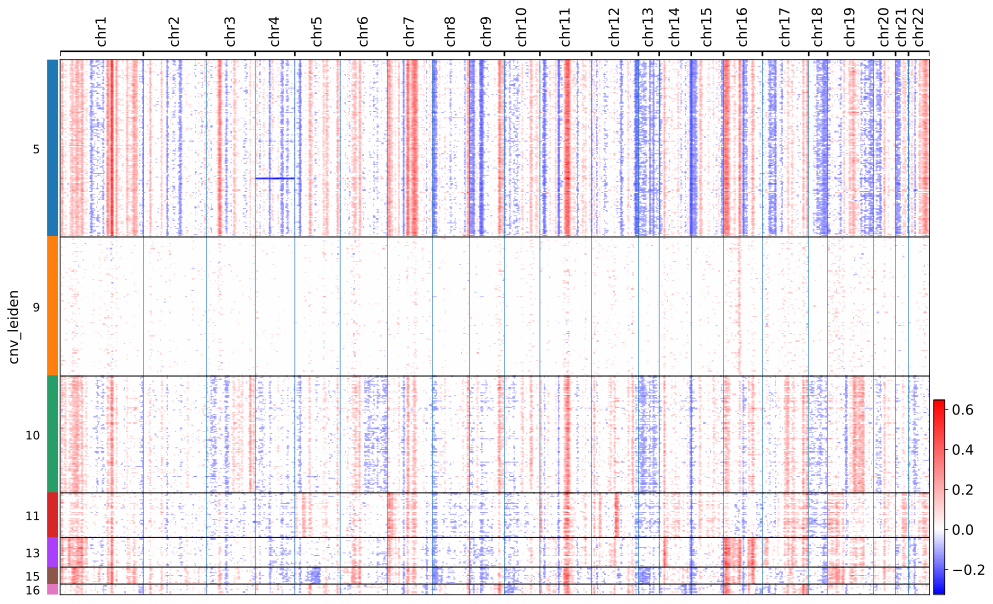

In [14]:
cnv.pl.chromosome_heatmap(adata[adata.obs["cnv_status"] == "tumor", :])

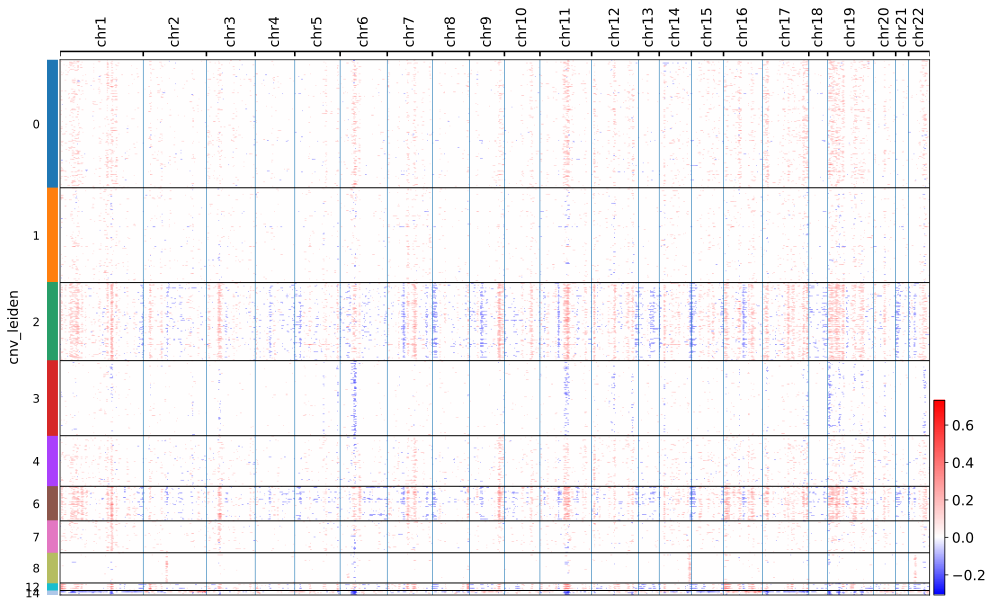

In [15]:
cnv.pl.chromosome_heatmap(adata[adata.obs["cnv_status"] == "normal", :])